- competition/dataset : [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- date : 2021/01/19
- original : [https://kaggle-kr.tistory.com/17?category=868316](https://kaggle-kr.tistory.com/17?category=868316)

## 타이타닉 튜토리얼 2 - Exploratory data analysis, visualization, machine learning

**✏ 필사 1회**

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df_train = pd.read_csv('../data/titanic_train.csv')
df_test = pd.read_csv('../data/titanic_test.csv')

In [3]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [4]:
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

### 3. Feature engineering
본격적인 feature engineering을 시작해보겠습니다.  

먼저 dataset에 존재하는 null data를 채우려고 합니다. null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다. null data를 채우는 방법에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써야 할 부분입니다.  

Feature engineering은 실제 모델의 학습에 사용하기 위한 것이므로 train뿐만 아니라 test도 똑같이 적용해주어야 합니다.

#### 3.1 Fill Null

##### 3.1.1 Fill Null in Age using title
Age에는 177개의 null data가 있습니다. 우리는 title과 statistics를 사용하여 채워보겠습니다. 영어에는 Miss, Mr, Mrs와 같은 title이 존재합니다. 각 탑승객의 이름에 꼭 이런 title이 들어가게 되는데, 이를 사용해보겠습니다.  

pandas series에는 data를 string으로 바꿔주는 str method, 정규표현식을 적용할 수 있도록 하는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.

In [5]:
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [6]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table을 참고하여 남성과 여성이 사용하는 initial을 구분해봅시다. replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환할 수 있습니다.

In [7]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)

In [8]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mrs의 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

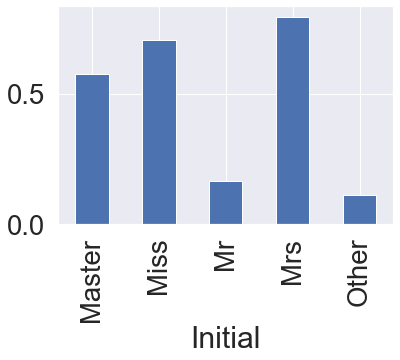

In [9]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 null을 채워봅시다. null data를 채우는 방법은 굉장히 많습니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.  

여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen 상태로 두어야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워야 합니다.

In [10]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 null value를 채워봅시다.  

pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 편리합니다. loc + boolean + column을 사용하여 값을 치환하는 방법은 자주 사용되므로 꼭 익숙해집시다.

In [11]:
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Other'), 'Age'] = 46

df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mr'), 'Age'] = 33
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mrs'), 'Age'] = 36
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Master'), 'Age'] = 5
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Miss'), 'Age'] = 22
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Other'), 'Age'] = 46

여기서는 간단하게 null을 채웠지만 다른 커널에서 다양한 방법을 쓴 예시들을 찾아볼 수 있습니다.  

[https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) << 참고해서 공부해보세요.  

##### 3.1.2 Fill Null in Embarked

In [12]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


Embarked의 null value는 2개이고, S의 탑승객이 가장 많았으므로 간단하게 null을 S로 채우겠습니다.  

dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True를 설정하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [13]:
df_train['Embarked'].fillna('S', inplace=True)

#### 3.2 Change Age (continuous to categorical)
Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수 있겠지만, 본 튜토리얼은 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.  

방법은 여러가지가 있습니다. dataframe의 indexing 방법인 loc를 사용하여 직접 해줄 수도 있고, apply를 사용해 함수를 넣어줄 수도 있습니다.  

첫 번째, loc를 사용한 방법입니다. 나이는 10살 간격으로 나누겠습니다.

In [14]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(df_train['Age'] >= 10)&(df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(df_train['Age'] >= 20)&(df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(df_train['Age'] >= 30)&(df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(df_train['Age'] >= 40)&(df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(df_train['Age'] >= 50)&(df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(df_train['Age'] >= 60)&(df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[df_train['Age'] >= 70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(df_test['Age'] >= 10)&(df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(df_test['Age'] >= 20)&(df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(df_test['Age'] >= 30)&(df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(df_test['Age'] >= 40)&(df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(df_test['Age'] >= 50)&(df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(df_test['Age'] >= 60)&(df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[df_test['Age'] >= 70, 'Age_cat'] = 7

두 번째로, 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.

In [15]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두 가지 방법이 잘 적용됐다면, 둘다 같은 결과를 내야합니다.  

이를 확인하기 위해 Series 간 boolean을 비교한 후 all() 메소드를 사용해봅시다. all() 메소드는 모든 값이 True이면 True, 하나라도 False가 있으면 False를 반환합니다.

In [16]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True ->  True


중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [17]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

#### 3.3 Change Initial, Embarked and Sex (string to numerical)
현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이러한 카테고리로 나뉜 데이터를 모델에 인풋으로 넣기 전에 먼저 컴퓨터가 인식할 수 있도록 수치화 시키는 작업이 필요합니다.  
map 메소드를 사용하여 사전 순서대로 정리하여 mapping 하겠습니다.

In [18]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

Embarked의 C, Q, S도 map을 이용해 바꿔보고자 합니다.  

바꾸기 전에 특정 column에 어떤 값이 있는지 잠시 확인해보겠습니다. 간단히 unique() 메소드를 쓰거나 value_counts()를 사용하여 count까지 보는 방법이 있습니다.

In [19]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [20]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위의 두 방법을 사용하여 Embarked가 S, C, Q 세 가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다.

In [21]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

이제 null이 없는지 확인해봅시다. Embarked column만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull() 메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 any()를 사용하면 True가 단 하나라도 있을 시(null이 한 개 이상) True를 반환합니다. 우리는 null을 모두 S로 바꾸어주었으므로 False를 얻습니다.

In [22]:
df_train['Embarked'].isnull().any()

False

Sex도 female과 mail로 이루어져있습니다. map을 이용해 바꿔봅시다.

In [23]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

각 feature 간 상관관계를 봅시다. 두 변수 간의 Pearson correlation을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1에 가까울수록 음의 상관관계, 1에 가까울수록 양의 상관관계를 의미하며 0은 상관관계가 없음을 의미합니다. 구하는 수식은 다음과 같습니다.  

$$r_{xy} = \frac{Cov(x, y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{S_{x}S_{y}}$$  

우리는 여러 feature를 가지고 있으니 이를 하나의 matrix 형태로 보면 편할텐데, 이를 heatmap plot이라고 하며, dataframe의 corr() 메소드와 seaborn을 가지고 편하게 그릴 수 있습니다.

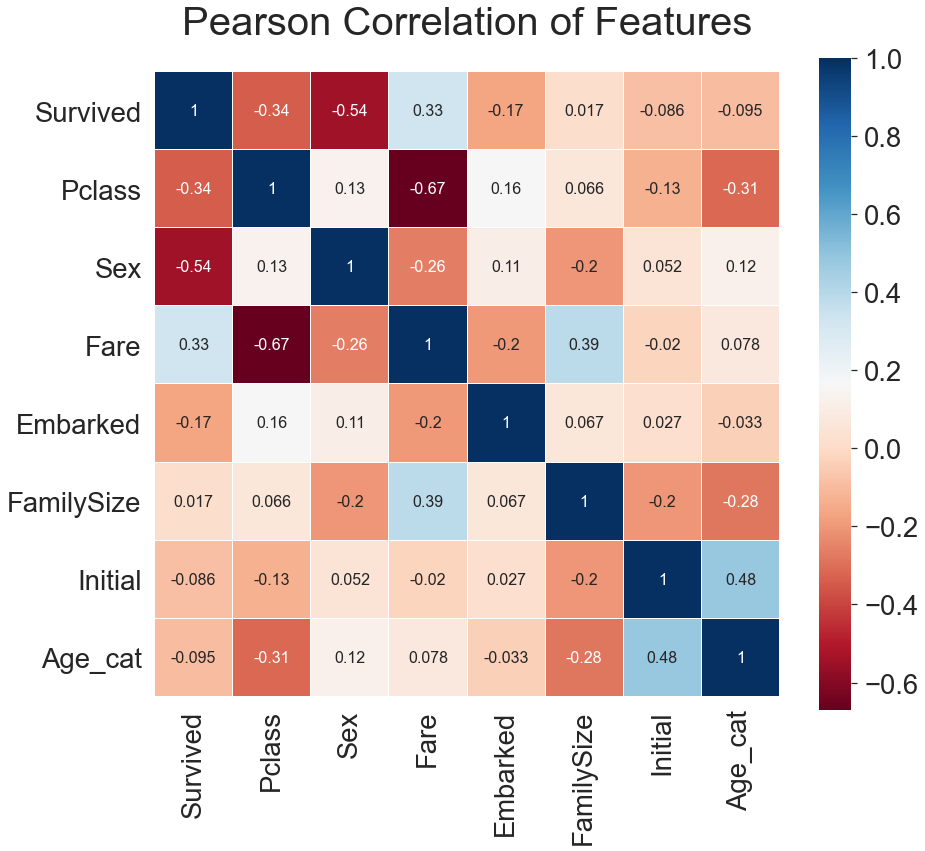

In [24]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=40)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data

EDA에서 살펴봤듯이, Sex와 Pclass가 Survived와 어느정도 상관관계가 있음을 볼 수 있습니다. 생각보다 Fare와 Embarked도 상관관계가 있음을 볼 수 있습니다.  

또한, 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 갖는 feature들이 없다는 것입니다. 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.  

이제 실제로 모델을 학습시키기에 앞서 data preprocessing(전처리)을 진행해보겠습니다.

#### 3.4 One-hot encoding on Initial and Embarked
수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.  

수치화는 간단히 Master = 0, Miss = 1, Mr = 2, Mrs = 3, Other = 4로 매핑해주는 것을 말합니다. One-hot encoding은 위 카테고리를 다음과 같이 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.  

(Initial) | Initial_Master | Initial_Miss | Initial_Mr | Initial_Mrs | Initial_Other
 :--: | :--: | :--: | :--: | :--: | :--:
 Master | 1 | 0 | 0 | 0 | 0
 Miss | 0 | 1 | 0 | 0 | 0
 Mr | 0 | 0 | 1 | 0 | 0
 Mrs | 0 | 0 | 0 | 1 | 0
 Others | 0 | 0 | 0 | 0 | 1  
 
 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결할 수 있습니다. 총 5개의 카테고리니, one-hot encoding을 만들고 나면 새로운 5개의 column이 생겨납니다. Initial을 prefix로 두어서 구분이 쉽게 만들어줍니다.

In [25]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [26]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0


우리가 만들려고 했던 one-hot encoded column들이 생성된 것을 볼 수 있습니다.  

Embarked에도 적용해보겠습니다. Initial과 마찬가지로 one-hot encoding을 사용해봅시다

In [27]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [28]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1


아주 쉽게 one-hot encoding을 적용했습니다.  

sklearn으로 Labelencoder + OneHotencoder를 이용해도 가능합니다. 여기서는 get_dummies로 충분히 가능하기 때문에 이 정도로 마치겠습니다.  

가끔 카테고리가 100개가 넘어가는 경우도 있스비다. 이때 one-hot encoding을 사용하면 column이 100개가 생기기 때문에 학습 시 매우 버거울 수 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

#### 3.5 Drop columns
필요한 columns만 남기고 다 지워보겠습니다.

In [29]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [30]:
df_train.head(3)

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1


In [31]:
df_test.head(3)

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0


train의 Survived feature(target class)를 제외하고는 train과 test가 모두 같은 column을 가진 것을 확인할 수 있습니다.

### 4. Building machin learning model and prediction using the trained model
sklearn을 사용하여 본걱적으로 머신러닝 모델을 만들어봅시다.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

sklearn은 머신러닝의 A부터 Z까지 모두 포함된 라이브러리입니다. feature engineering, preprocessing, 지도학습 알고리즘, 비지도학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있스비다. 데이터 분석 + 머신러닝을 하고 싶다면, 이 라이브러리는 반드시 숙지해야 합니다.  

책 『파이썬 라이브러리를 활용한 머신러닝(Introduction to machin learning with Python)』으로 공부하는 것을 추천합니다.  

타이타닉 컴피티션으 경우 target class(Survived)가 있으며, 0과 1로 이루어져 있으므로 binary classification 문제입니다. train set에서 Survived를 제외한 input으로 모델을 최적화시켜 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어봅시다. 그 다음 모델이 학습하지 않았던 test set을 input으로 주어 test set의 각 샘플(탑승객)의 생존 유무를 예측해봅시다.

#### 4.1 Preparation - split dataset into train, valid, test set
가장 먼저, 학습에 쓰일 데이터와 target label(Survived)를 분리합니다.

In [34]:
x_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
x_test = df_test.values

일반적으로 train, test만 언급하지만, 좋은 모델을 만들기 위해 valid set을 따로 만들어 모델 평가를 해봅시다.  

(이는 마치 축구대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)에 출전하는 것이 아니라, 팀 훈련(train) 뒤 평가전(valid)을 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 출전하는 것과 비슷합니다.  

train_test_split을 사용하여 쉽게 train set을 분리할 수 있습니다.

In [35]:
x_tr, x_vld, y_tr, y_vld = train_test_split(x_train, target_label, test_size=0.3, random_state=123)

sklearn에서는 여러 머신러닝 알고리즘을 지원합니다. 직접 [documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning)에 들어가서 공부하길 추천합니다.  

본 튜토리얼에서는 랜덤포레스트 모델을 사용하겠습니다. 랜덤포레스트는 의사결정나무 기반 모델이며, 여러 decision tree들을 앙상블한 모델입니다.  

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트 분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.  

파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 캐글의 여러 데이터셋을 다루며 모델을 이리저리 써보면 튜닝하는 감이 생길 수 있을 것입니다. 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두고, 기본 default 세팅으로 진행하겠습니다.  

모델 객체를 만들고, fit 메소드로 학습시킨 뒤 valid set input을 넣어주어 예측값(x_vld sample(탑승객)의 생존여부)을 얻습니다.

#### 4.2 Model generation and prediction

In [36]:
model = RandomForestClassifier()
model.fit(x_tr, y_tr)
prediction = model.predict(x_vld)

단 세 줄만으로 모델을 세우고, 예측까지 해보았습니다. 이제 모델의 성능을 살펴보겠습니다.

In [37]:
print('총 {}명 중 {:.2f}% 정확도로 생존유무를 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.46% 정확도로 생존유무를 맞춤


#### 4.3 Feature importance
학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다. pandas series를 이용하면 쉽게 sorting하여 그래프를 그릴 수 있습니다.

In [40]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

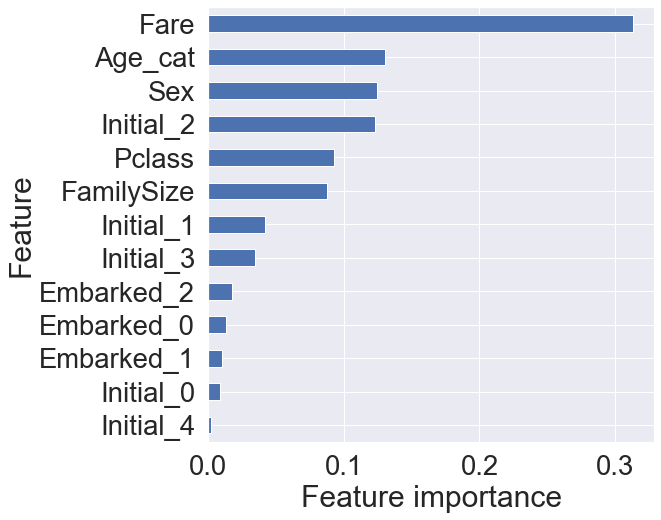

In [43]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 Age_cat, Sex, Initial_2가 차례로 높은 중요도를 가집니다. 이는 해당 모델에서의 importance이므로 다른 모델에서는 다른 결과를 가져올 수 있습니다.  

이 feature importance를 보고 실제 Fare가 중요한 feature라고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 더 살펴볼 필요가 있습니다.  

feature importance를 가지고 정확도가 보다 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

#### 4.4 Prediction on Test set
test set을 모델에 입력하여 생존여부를 예측해보겠습니다. 이 결과는 실제로 submission이므로 결과는 leaderboard에서 확인할 수 있습니다.

In [44]:
submission = pd.read_csv('../data/titanic_gender_submission.csv')

In [46]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [47]:
prediction = model.predict(x_test)
submission['Survived'] = prediction

In [48]:
submission.to_csv('../data/submission_titanic.csv', index=False)

## 타이타닉 튜토리얼 2 - Exploratory data analysis, visualization, machine learning

**✏ 필사 2회**

In [50]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [51]:
df_train = pd.read_csv('../data/titanic_train.csv')
df_test = pd.read_csv('../data/titanic_test.csv')

In [52]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [53]:
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

### 3. Feature engineering
본격적인 feature engineering을 시작해보겠습니다.  

먼저 dataset에 존재하는 null data를 채우려고 합니다. null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다. null data를 채우는 방법에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써야 할 부분입니다.  

Feature engineering은 실제 모델의 학습에 사용하기 위한 것이므로 train뿐만 아니라 test도 똑같이 적용해주어야 합니다.

#### 3.1 Fill Null

##### 3.1.1 Fill Null in Age using title
Age에는 177개의 null data가 있습니다. 우리는 title과 statistics를 사용하여 채워보겠습니다. 영어에는 Miss, Mr, Mrs와 같은 title이 존재합니다. 각 탑승객의 이름에 꼭 이런 title이 들어가게 되는데, 이를 사용해보겠습니다.  

pandas series에는 data를 string으로 바꿔주는 str method, 정규표현식을 적용할 수 있도록 하는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.

In [54]:
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [55]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table을 참고하여 남성과 여성이 사용하는 initial을 구분해봅시다. replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환할 수 있습니다.

In [56]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)

In [59]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mrs의 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

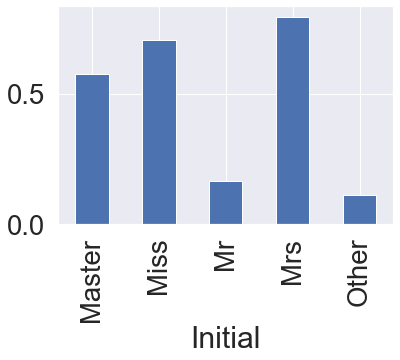

In [60]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 null을 채워봅시다. null data를 채우는 방법은 굉장히 많습니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.  

여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen 상태로 두어야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워야 합니다.

In [61]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 null value를 채워봅시다.  

pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 편리합니다. loc + boolean + column을 사용하여 값을 치환하는 방법은 자주 사용되므로 꼭 익숙해집시다.

In [62]:
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Other'), 'Age'] = 46

df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mr'), 'Age'] = 33
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mrs'), 'Age'] = 36
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Master'), 'Age'] = 5
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Miss'), 'Age'] = 22
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Other'), 'Age'] = 46

여기서는 간단하게 null을 채웠지만 다른 커널에서 다양한 방법을 쓴 예시들을 찾아볼 수 있습니다.  

[https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) << 참고해서 공부해보세요.  

##### 3.1.2 Fill Null in Embarked

In [64]:
print('Embarked has {} Null values'.format(sum(df_train['Embarked'].isnull())))

Embarked has 2 Null values


Embarked의 null value는 2개이고, S의 탑승객이 가장 많았으므로 간단하게 null을 S로 채우겠습니다.  

dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True를 설정하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [65]:
df_train['Embarked'].fillna('S', inplace=True)

#### 3.2 Change Age (continuous to categorical)
Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수 있겠지만, 본 튜토리얼은 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.  

방법은 여러가지가 있습니다. dataframe의 indexing 방법인 loc를 사용하여 직접 해줄 수도 있고, apply를 사용해 함수를 넣어줄 수도 있습니다.  

첫 번째, loc를 사용한 방법입니다. 나이는 10살 간격으로 나누겠습니다.

In [66]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(df_train['Age'] >= 10)&(df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(df_train['Age'] >= 20)&(df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(df_train['Age'] >= 30)&(df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(df_train['Age'] >= 40)&(df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(df_train['Age'] >= 50)&(df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(df_train['Age'] >= 60)&(df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[df_train['Age'] >= 70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(df_test['Age'] >= 10)&(df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(df_test['Age'] >= 20)&(df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(df_test['Age'] >= 30)&(df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(df_test['Age'] >= 40)&(df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(df_test['Age'] >= 50)&(df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(df_test['Age'] >= 60)&(df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[df_test['Age'] >= 70, 'Age_cat'] = 7

두 번째로, 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.

In [67]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두 가지 방법이 잘 적용됐다면, 둘다 같은 결과를 내야합니다.  

이를 확인하기 위해 Series 간 boolean을 비교한 후 all() 메소드를 사용해봅시다. all() 메소드는 모든 값이 True이면 True, 하나라도 False가 있으면 False를 반환합니다.

In [70]:
print(f"1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> {(df_train['Age_cat'] == df_train['Age_cat_2']).all()}")

1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> True


중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [71]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

#### 3.3 Change Initial, Embarked and Sex (string to numerical)
현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이러한 카테고리로 나뉜 데이터를 모델에 인풋으로 넣기 전에 먼저 컴퓨터가 인식할 수 있도록 수치화 시키는 작업이 필요합니다.  
map 메소드를 사용하여 사전 순서대로 정리하여 mapping 하겠습니다.

In [72]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

Embarked의 C, Q, S도 map을 이용해 바꿔보고자 합니다.  

바꾸기 전에 특정 column에 어떤 값이 있는지 잠시 확인해보겠습니다. 간단히 unique() 메소드를 쓰거나 value_counts()를 사용하여 count까지 보는 방법이 있습니다.

In [73]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [74]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위의 두 방법을 사용하여 Embarked가 S, C, Q 세 가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다.

In [75]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

이제 null이 없는지 확인해봅시다. Embarked column만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull() 메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 any()를 사용하면 True가 단 하나라도 있을 시(null이 한 개 이상) True를 반환합니다. 우리는 null을 모두 S로 바꾸어주었으므로 False를 얻습니다.

In [76]:
df_train['Embarked'].isnull().any()

False

Sex도 female과 mail로 이루어져있습니다. map을 이용해 바꿔봅시다.

In [77]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

각 feature 간 상관관계를 봅시다. 두 변수 간의 Pearson correlation을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1에 가까울수록 음의 상관관계, 1에 가까울수록 양의 상관관계를 의미하며 0은 상관관계가 없음을 의미합니다. 구하는 수식은 다음과 같습니다.  

$$r_{xy} = \frac{Cov(x, y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{S_{x}S_{y}}$$  

우리는 여러 feature를 가지고 있으니 이를 하나의 matrix 형태로 보면 편할텐데, 이를 heatmap plot이라고 하며, dataframe의 corr() 메소드와 seaborn을 가지고 편하게 그릴 수 있습니다.

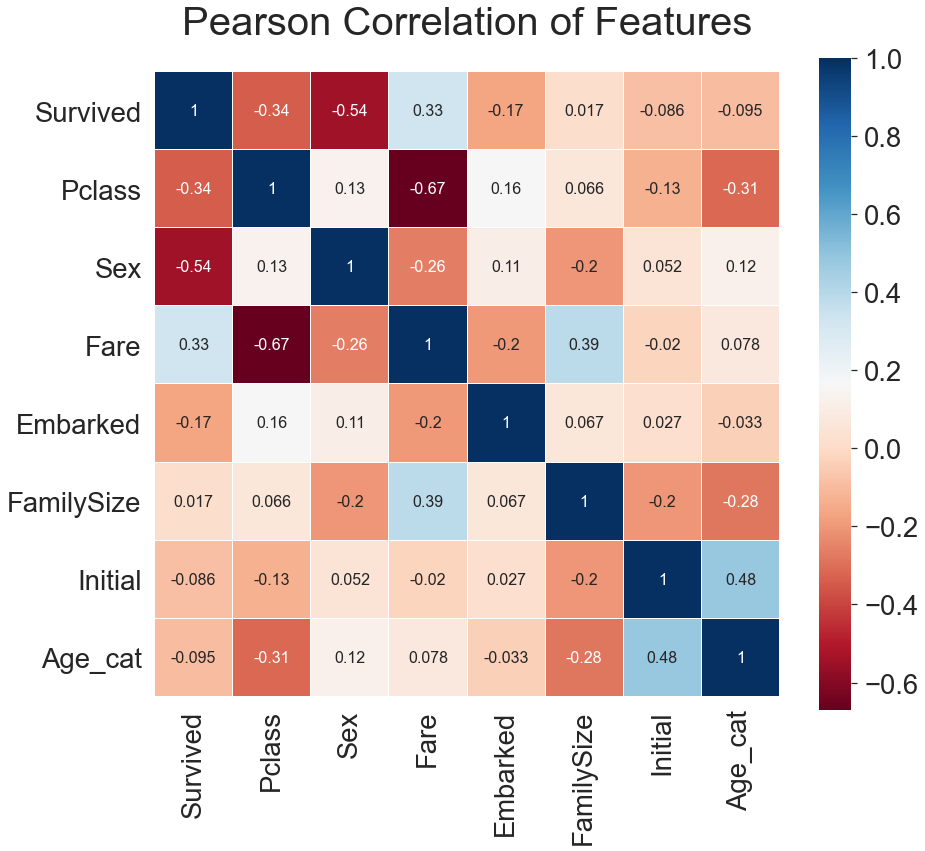

In [85]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=40)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data

EDA에서 살펴봤듯이, Sex와 Pclass가 Survived와 어느정도 상관관계가 있음을 볼 수 있습니다. 생각보다 Fare와 Embarked도 상관관계가 있음을 볼 수 있습니다.  

또한, 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 갖는 feature들이 없다는 것입니다. 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.  

이제 실제로 모델을 학습시키기에 앞서 data preprocessing(전처리)을 진행해보겠습니다.

#### 3.4 One-hot encoding on Initial and Embarked
수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.  

수치화는 간단히 Master = 0, Miss = 1, Mr = 2, Mrs = 3, Other = 4로 매핑해주는 것을 말합니다. One-hot encoding은 위 카테고리를 다음과 같이 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.  

(Initial) | Initial_Master | Initial_Miss | Initial_Mr | Initial_Mrs | Initial_Other
 :--: | :--: | :--: | :--: | :--: | :--:
 Master | 1 | 0 | 0 | 0 | 0
 Miss | 0 | 1 | 0 | 0 | 0
 Mr | 0 | 0 | 1 | 0 | 0
 Mrs | 0 | 0 | 0 | 1 | 0
 Others | 0 | 0 | 0 | 0 | 1  
 
 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결할 수 있습니다. 총 5개의 카테고리니, one-hot encoding을 만들고 나면 새로운 5개의 column이 생겨납니다. Initial을 prefix로 두어서 구분이 쉽게 만들어줍니다.

In [86]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [87]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0


우리가 만들려고 했던 one-hot encoded column들이 생성된 것을 볼 수 있습니다.  

Embarked에도 적용해보겠습니다. Initial과 마찬가지로 one-hot encoding을 사용해봅시다

In [88]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [28]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1


아주 쉽게 one-hot encoding을 적용했습니다.  

sklearn으로 Labelencoder + OneHotencoder를 이용해도 가능합니다. 여기서는 get_dummies로 충분히 가능하기 때문에 이 정도로 마치겠습니다.  

가끔 카테고리가 100개가 넘어가는 경우도 있스비다. 이때 one-hot encoding을 사용하면 column이 100개가 생기기 때문에 학습 시 매우 버거울 수 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

#### 3.5 Drop columns
필요한 columns만 남기고 다 지워보겠습니다.

In [89]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [90]:
df_train.head(3)

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1


In [91]:
df_test.head(3)

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0


train의 Survived feature(target class)를 제외하고는 train과 test가 모두 같은 column을 가진 것을 확인할 수 있습니다.

### 4. Building machin learning model and prediction using the trained model
sklearn을 사용하여 본걱적으로 머신러닝 모델을 만들어봅시다.

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

sklearn은 머신러닝의 A부터 Z까지 모두 포함된 라이브러리입니다. feature engineering, preprocessing, 지도학습 알고리즘, 비지도학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있스비다. 데이터 분석 + 머신러닝을 하고 싶다면, 이 라이브러리는 반드시 숙지해야 합니다.  

책 『파이썬 라이브러리를 활용한 머신러닝(Introduction to machin learning with Python)』으로 공부하는 것을 추천합니다.  

타이타닉 컴피티션으 경우 target class(Survived)가 있으며, 0과 1로 이루어져 있으므로 binary classification 문제입니다. train set에서 Survived를 제외한 input으로 모델을 최적화시켜 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어봅시다. 그 다음 모델이 학습하지 않았던 test set을 input으로 주어 test set의 각 샘플(탑승객)의 생존 유무를 예측해봅시다.

#### 4.1 Preparation - split dataset into train, valid, test set
가장 먼저, 학습에 쓰일 데이터와 target label(Survived)를 분리합니다.

In [93]:
x_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
x_test = df_test.values

일반적으로 train, test만 언급하지만, 좋은 모델을 만들기 위해 valid set을 따로 만들어 모델 평가를 해봅시다.  

(이는 마치 축구대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)에 출전하는 것이 아니라, 팀 훈련(train) 뒤 평가전(valid)을 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 출전하는 것과 비슷합니다.  

train_test_split을 사용하여 쉽게 train set을 분리할 수 있습니다.

In [94]:
x_tr, x_vld, y_tr, y_vld = train_test_split(x_train, target_label, test_size=0.3, random_state=123)

sklearn에서는 여러 머신러닝 알고리즘을 지원합니다. 직접 [documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning)에 들어가서 공부하길 추천합니다.  

본 튜토리얼에서는 랜덤포레스트 모델을 사용하겠습니다. 랜덤포레스트는 의사결정나무 기반 모델이며, 여러 decision tree들을 앙상블한 모델입니다.  

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트 분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.  

파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 캐글의 여러 데이터셋을 다루며 모델을 이리저리 써보면 튜닝하는 감이 생길 수 있을 것입니다. 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두고, 기본 default 세팅으로 진행하겠습니다.  

모델 객체를 만들고, fit 메소드로 학습시킨 뒤 valid set input을 넣어주어 예측값(x_vld sample(탑승객)의 생존여부)을 얻습니다.

#### 4.2 Model generation and prediction

In [95]:
model = RandomForestClassifier()
model.fit(x_tr, y_tr)
prediction = model.predict(x_vld)

단 세 줄만으로 모델을 세우고, 예측까지 해보았습니다. 이제 모델의 성능을 살펴보겠습니다.

In [96]:
print('총 {}명 중 {:.2f}% 정확도로 생존유무를 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 83.58% 정확도로 생존유무를 맞춤


#### 4.3 Feature importance
학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다. pandas series를 이용하면 쉽게 sorting하여 그래프를 그릴 수 있습니다.

In [97]:
feature_importance = model.feature_importances_
Series_feat_map = Series(feature_importance, index=df_test.columns)

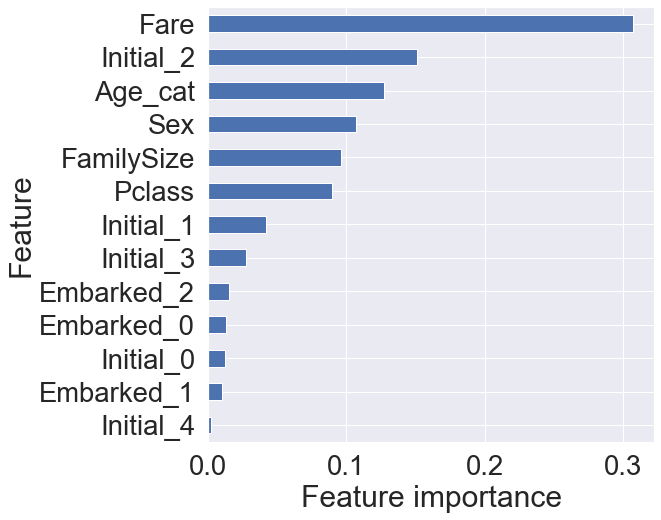

In [99]:
plt.figure(figsize=(8, 8))
Series_feat_map.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Sex가 차례로 높은 중요도를 가집니다. 이는 해당 모델에서의 importance이므로 다른 모델에서는 다른 결과를 가져올 수 있습니다.  

이 feature importance를 보고 실제 Fare가 중요한 feature라고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 더 살펴볼 필요가 있습니다.  

feature importance를 가지고 정확도가 보다 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

#### 4.4 Prediction on Test set
test set을 모델에 입력하여 생존여부를 예측해보겠습니다. 이 결과는 실제로 submission이므로 결과는 leaderboard에서 확인할 수 있습니다.

In [100]:
submission = pd.read_csv('../data/titanic_gender_submission.csv')

In [101]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [102]:
prediction = model.predict(x_test)
submission['Survived'] = prediction

In [103]:
submission.to_csv('../data/submission_titanic.csv', index=False)

## 타이타닉 튜토리얼 2 - Exploratory data analysis, visualization, machine learning

**✏ 필사 3회**

In [104]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [105]:
df_train = pd.read_csv('../data/titanic_train.csv')
df_test = pd.read_csv('../data/titanic_test.csv')

In [106]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [107]:
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

### 3. Feature engineering
본격적인 feature engineering을 시작해보겠습니다.  

먼저 dataset에 존재하는 null data를 채우려고 합니다. null data를 포함하는 feature의 statistics를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다. null data를 채우는 방법에 따라 모델의 성능이 좌지우지될 수 있기 때문에 신경써야 할 부분입니다.  

Feature engineering은 실제 모델의 학습에 사용하기 위한 것이므로 train뿐만 아니라 test도 똑같이 적용해주어야 합니다.

#### 3.1 Fill Null

##### 3.1.1 Fill Null in Age using title
Age에는 177개의 null data가 있습니다. 우리는 title과 statistics를 사용하여 채워보겠습니다. 영어에는 Miss, Mr, Mrs와 같은 title이 존재합니다. 각 탑승객의 이름에 꼭 이런 title이 들어가게 되는데, 이를 사용해보겠습니다.  

pandas series에는 data를 string으로 바꿔주는 str method, 정규표현식을 적용할 수 있도록 하는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.

In [109]:
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [111]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table을 참고하여 남성과 여성이 사용하는 initial을 구분해봅시다. replace 메소드를 사용하면 특정 데이터 값을 원하는 값으로 치환할 수 있습니다.

In [112]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)
df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)

In [113]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mrs의 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

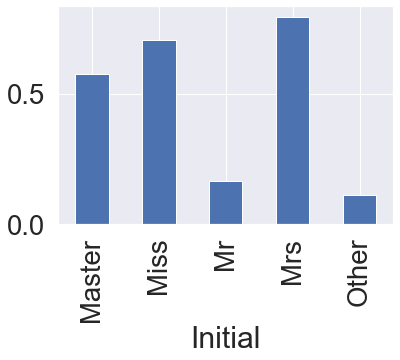

In [114]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 null을 채워봅시다. null data를 채우는 방법은 굉장히 많습니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.  

여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test를 unseen 상태로 두어야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워야 합니다.

In [115]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 null value를 채워봅시다.  

pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 편리합니다. loc + boolean + column을 사용하여 값을 치환하는 방법은 자주 사용되므로 꼭 익숙해집시다.

In [116]:
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isnull())&(df_train['Initial']=='Other'), 'Age'] = 46

df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mr'), 'Age'] = 33
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Mrs'), 'Age'] = 36
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Master'), 'Age'] = 5
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Miss'), 'Age'] = 22
df_test.loc[(df_test['Age'].isnull())&(df_test['Initial']=='Other'), 'Age'] = 46

여기서는 간단하게 null을 채웠지만 다른 커널에서 다양한 방법을 쓴 예시들을 찾아볼 수 있습니다.  

[https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling) << 참고해서 공부해보세요.  

##### 3.1.2 Fill Null in Embarked

In [117]:
print('Embarked has {} Null values'.format(sum(df_train['Embarked'].isnull())))

Embarked has 2 Null values


Embarked의 null value는 2개이고, S의 탑승객이 가장 많았으므로 간단하게 null을 S로 채우겠습니다.  

dataframe의 fillna method를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True를 설정하면 df_train에 fillna를 실제로 적용하게 됩니다.

In [118]:
df_train['Embarked'].fillna('S', inplace=True)

#### 3.2 Change Age (continuous to categorical)
Age는 현재 continuous feature입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇 개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수 있겠지만, 본 튜토리얼은 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.  

방법은 여러가지가 있습니다. dataframe의 indexing 방법인 loc를 사용하여 직접 해줄 수도 있고, apply를 사용해 함수를 넣어줄 수도 있습니다.  

첫 번째, loc를 사용한 방법입니다. 나이는 10살 간격으로 나누겠습니다.

In [119]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(df_train['Age'] >= 10)&(df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(df_train['Age'] >= 20)&(df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(df_train['Age'] >= 30)&(df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(df_train['Age'] >= 40)&(df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(df_train['Age'] >= 50)&(df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(df_train['Age'] >= 60)&(df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[df_train['Age'] >= 70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(df_test['Age'] >= 10)&(df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(df_test['Age'] >= 20)&(df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(df_test['Age'] >= 30)&(df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(df_test['Age'] >= 40)&(df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(df_test['Age'] >= 50)&(df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(df_test['Age'] >= 60)&(df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[df_test['Age'] >= 70, 'Age_cat'] = 7

두 번째로, 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.

In [120]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두 가지 방법이 잘 적용됐다면, 둘다 같은 결과를 내야합니다.  

이를 확인하기 위해 Series 간 boolean을 비교한 후 all() 메소드를 사용해봅시다. all() 메소드는 모든 값이 True이면 True, 하나라도 False가 있으면 False를 반환합니다.

In [121]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> {}'.format((df_train['Age_cat']==df_train['Age_cat_2']).any()))

1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> True


중복되는 Age_cat 컬럼과 원래 컬럼 Age를 제거하겠습니다.

In [122]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop('Age', axis=1, inplace=True)

#### 3.3 Change Initial, Embarked and Sex (string to numerical)
현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이러한 카테고리로 나뉜 데이터를 모델에 인풋으로 넣기 전에 먼저 컴퓨터가 인식할 수 있도록 수치화 시키는 작업이 필요합니다.  
map 메소드를 사용하여 사전 순서대로 정리하여 mapping 하겠습니다.

In [123]:
df_train['Initial'] = df_train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

Embarked의 C, Q, S도 map을 이용해 바꿔보고자 합니다.  

바꾸기 전에 특정 column에 어떤 값이 있는지 잠시 확인해보겠습니다. 간단히 unique() 메소드를 쓰거나 value_counts()를 사용하여 count까지 보는 방법이 있습니다.

In [124]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [125]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위의 두 방법을 사용하여 Embarked가 S, C, Q 세 가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다.

In [126]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

이제 null이 없는지 확인해봅시다. Embarked column만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull() 메소드를 사용해 Series의 값들이 null인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 any()를 사용하면 True가 단 하나라도 있을 시(null이 한 개 이상) True를 반환합니다. 우리는 null을 모두 S로 바꾸어주었으므로 False를 얻습니다.

In [127]:
df_train['Embarked'].isnull().any()

False

Sex도 female과 mail로 이루어져있습니다. map을 이용해 바꿔봅시다.

In [128]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

각 feature 간 상관관계를 봅시다. 두 변수 간의 Pearson correlation을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1에 가까울수록 음의 상관관계, 1에 가까울수록 양의 상관관계를 의미하며 0은 상관관계가 없음을 의미합니다. 구하는 수식은 다음과 같습니다.  

$$r_{xy} = \frac{Cov(x, y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{S_{x}S_{y}}$$  

우리는 여러 feature를 가지고 있으니 이를 하나의 matrix 형태로 보면 편할텐데, 이를 heatmap plot이라고 하며, dataframe의 corr() 메소드와 seaborn을 가지고 편하게 그릴 수 있습니다.

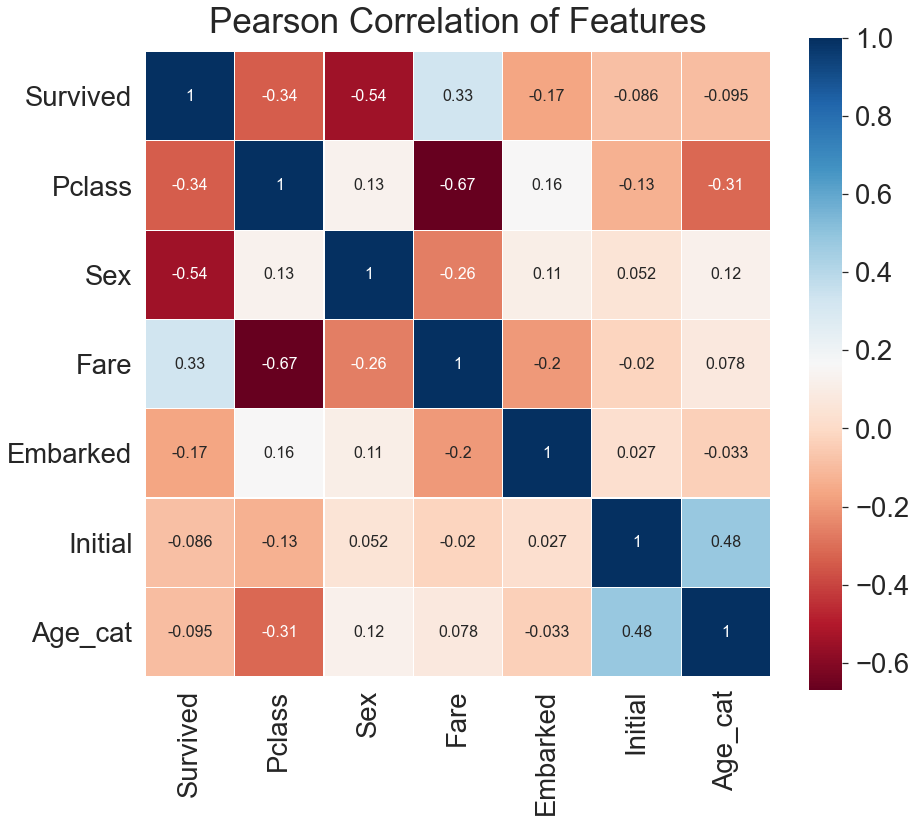

In [129]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.02, size=35)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size':16})

del heatmap_data

EDA에서 살펴봤듯이, Sex와 Pclass가 Survived와 어느정도 상관관계가 있음을 볼 수 있습니다. 생각보다 Fare와 Embarked도 상관관계가 있음을 볼 수 있습니다.  

또한, 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 갖는 feature들이 없다는 것입니다. 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.  

이제 실제로 모델을 학습시키기에 앞서 data preprocessing(전처리)을 진행해보겠습니다.

#### 3.4 One-hot encoding on Initial and Embarked
수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.  

수치화는 간단히 Master = 0, Miss = 1, Mr = 2, Mrs = 3, Other = 4로 매핑해주는 것을 말합니다. One-hot encoding은 위 카테고리를 다음과 같이 (0, 1)로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.  

(Initial) | Initial_Master | Initial_Miss | Initial_Mr | Initial_Mrs | Initial_Other
 :--: | :--: | :--: | :--: | :--: | :--:
 Master | 1 | 0 | 0 | 0 | 0
 Miss | 0 | 1 | 0 | 0 | 0
 Mr | 0 | 0 | 1 | 0 | 0
 Mrs | 0 | 0 | 0 | 1 | 0
 Others | 0 | 0 | 0 | 0 | 1  
 
 위와 같은 작업을 직접 코딩할 수도 있지만, pandas의 get_dummies를 사용하여 쉽게 해결할 수 있습니다. 총 5개의 카테고리니, one-hot encoding을 만들고 나면 새로운 5개의 column이 생겨납니다. Initial을 prefix로 두어서 구분이 쉽게 만들어줍니다.

In [130]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [131]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0


우리가 만들려고 했던 one-hot encoded column들이 생성된 것을 볼 수 있습니다.  

Embarked에도 적용해보겠습니다. Initial과 마찬가지로 one-hot encoding을 사용해봅시다

In [132]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [133]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,2,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,1,2,0,1,0,0,0,0,0,1


아주 쉽게 one-hot encoding을 적용했습니다.  

sklearn으로 Labelencoder + OneHotencoder를 이용해도 가능합니다. 여기서는 get_dummies로 충분히 가능하기 때문에 이 정도로 마치겠습니다.  

가끔 카테고리가 100개가 넘어가는 경우도 있스비다. 이때 one-hot encoding을 사용하면 column이 100개가 생기기 때문에 학습 시 매우 버거울 수 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

#### 3.5 Drop columns
필요한 columns만 남기고 다 지워보겠습니다.

In [134]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [135]:
df_train.head(3)

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1


In [136]:
df_test.head(3)

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0


train의 Survived feature(target class)를 제외하고는 train과 test가 모두 같은 column을 가진 것을 확인할 수 있습니다.

### 4. Building machin learning model and prediction using the trained model
sklearn을 사용하여 본걱적으로 머신러닝 모델을 만들어봅시다.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

sklearn은 머신러닝의 A부터 Z까지 모두 포함된 라이브러리입니다. feature engineering, preprocessing, 지도학습 알고리즘, 비지도학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있스비다. 데이터 분석 + 머신러닝을 하고 싶다면, 이 라이브러리는 반드시 숙지해야 합니다.  

책 『파이썬 라이브러리를 활용한 머신러닝(Introduction to machin learning with Python)』으로 공부하는 것을 추천합니다.  

타이타닉 컴피티션으 경우 target class(Survived)가 있으며, 0과 1로 이루어져 있으므로 binary classification 문제입니다. train set에서 Survived를 제외한 input으로 모델을 최적화시켜 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어봅시다. 그 다음 모델이 학습하지 않았던 test set을 input으로 주어 test set의 각 샘플(탑승객)의 생존 유무를 예측해봅시다.

#### 4.1 Preparation - split dataset into train, valid, test set
가장 먼저, 학습에 쓰일 데이터와 target label(Survived)를 분리합니다.

In [139]:
x_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
x_test = df_test.values

일반적으로 train, test만 언급하지만, 좋은 모델을 만들기 위해 valid set을 따로 만들어 모델 평가를 해봅시다.  

(이는 마치 축구대표팀이 팀 훈련(train)을 하고 바로 월드컵(test)에 출전하는 것이 아니라, 팀 훈련(train) 뒤 평가전(valid)을 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 출전하는 것과 비슷합니다.  

train_test_split을 사용하여 쉽게 train set을 분리할 수 있습니다.

In [140]:
x_tr, x_vld, y_tr, y_vld = train_test_split(x_train, target_label, test_size=0.3, random_state=2018)

sklearn에서는 여러 머신러닝 알고리즘을 지원합니다. 직접 [documentation](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning)에 들어가서 공부하길 추천합니다.  

본 튜토리얼에서는 랜덤포레스트 모델을 사용하겠습니다. 랜덤포레스트는 의사결정나무 기반 모델이며, 여러 decision tree들을 앙상블한 모델입니다.  

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트 분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.  

파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 캐글의 여러 데이터셋을 다루며 모델을 이리저리 써보면 튜닝하는 감이 생길 수 있을 것입니다. 일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두고, 기본 default 세팅으로 진행하겠습니다.  

모델 객체를 만들고, fit 메소드로 학습시킨 뒤 valid set input을 넣어주어 예측값(x_vld sample(탑승객)의 생존여부)을 얻습니다.

#### 4.2 Model generation and prediction

In [141]:
model = RandomForestClassifier()
model.fit(x_tr, y_tr)
prediction = model.predict(x_vld)

단 세 줄만으로 모델을 세우고, 예측까지 해보았습니다. 이제 모델의 성능을 살펴보겠습니다.

In [144]:
print('총 {}명 중 {:.2f}% 정확도로 생존여부를 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.46% 정확도로 생존여부를 맞춤


#### 4.3 Feature importance
학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature에 영향을 많이 받았는지 확인할 수 있습니다. pandas series를 이용하면 쉽게 sorting하여 그래프를 그릴 수 있습니다.

In [145]:
feature_importance = model.feature_importances_
Series_feat_map = Series(feature_importance, index=df_test.columns)

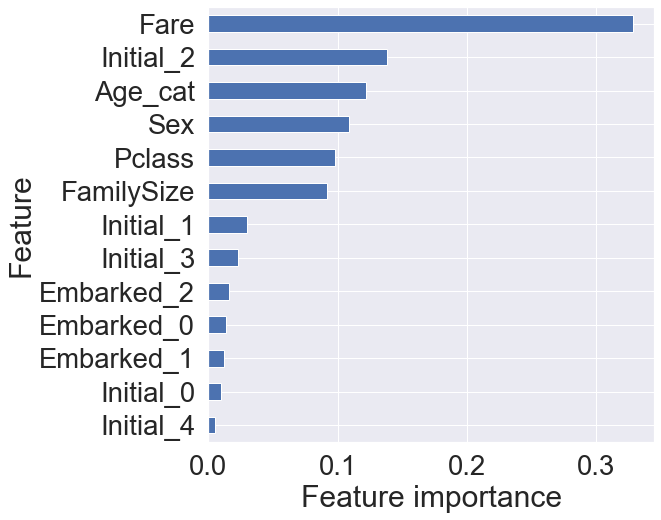

In [147]:
plt.figure(figsize=(8, 8))
Series_feat_map.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Sex가 차례로 높은 중요도를 가집니다. 이는 해당 모델에서의 importance이므로 다른 모델에서는 다른 결과를 가져올 수 있습니다.  

이 feature importance를 보고 실제 Fare가 중요한 feature라고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 더 살펴볼 필요가 있습니다.  

feature importance를 가지고 정확도가 보다 높은 모델을 얻기 위해 feature selection을 할 수도 있고, 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

#### 4.4 Prediction on Test set
test set을 모델에 입력하여 생존여부를 예측해보겠습니다. 이 결과는 실제로 submission이므로 결과는 leaderboard에서 확인할 수 있습니다.

In [148]:
submission = pd.read_csv('../data/titanic_gender_submission.csv')

In [149]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [150]:
prediction = model.predict(x_test)
submission['Survived'] = prediction

In [151]:
submission.to_csv('../data/submission_titanic.csv', index=False)